In [20]:
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import plot_importance

<Axes: xlabel='distance_from_center', ylabel='z'>

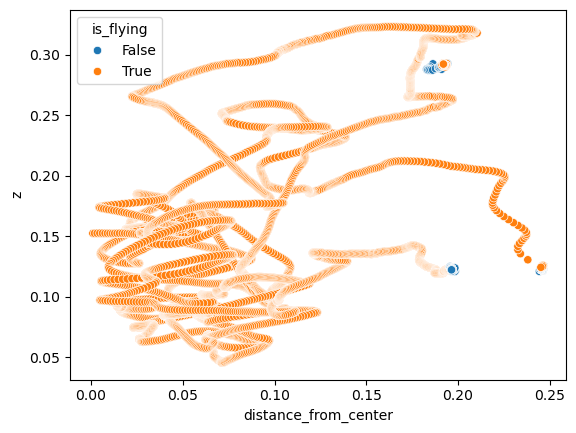

In [37]:
# Load and preprocess data
def load_data(file_pattern):
    all_files = glob.glob(file_pattern)
    df_list = [pd.read_csv(file) for file in all_files]
    df = pd.concat(df_list, ignore_index=True)
    return df

df = load_data('data/*.csv')

sns.scatterplot(data=df, x='distance_from_center', y='z', hue='is_flying')


# Models

## Logistic Regression

In [18]:
# Load and preprocess data
def load_data(file_pattern):
    all_files = glob.glob(file_pattern)
    df_list = [pd.read_csv(file) for file in all_files]
    df = pd.concat(df_list, ignore_index=True)
    return df

df = load_data('data/*.csv')

# Select features and target
features = ['x', 'y', 'z', 'xvel', 'yvel', 'zvel', 'linear_velocity', 'angular_velocity']
X = df[features]
y = df['is_flying']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the model
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Analyze feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': abs(model.coef_[0])
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance in Logistic Regression Model')
plt.tight_layout()
plt.savefig('data/models/logistic_regression/feature_importance.png')
plt.close()

print("\nFeature Importance:")
print(feature_importance)
print("\nFeature importance plot saved as 'feature_importance.png'")

# Save the model
import joblib

joblib.dump(model, 'data/models/logistic_regression/fly_trajectory_model.joblib')
joblib.dump(scaler, 'data/models/logistic_regression/fly_trajectory_scaler.joblib')
print("\nModel and scaler saved as 'fly_trajectory_model.joblib' and 'fly_trajectory_scaler.joblib'")

Accuracy: 0.92

Classification Report:
              precision    recall  f1-score   support

       False       0.89      0.89      0.89      5335
        True       0.94      0.94      0.94      9249

    accuracy                           0.92     14584
   macro avg       0.92      0.91      0.91     14584
weighted avg       0.92      0.92      0.92     14584


Feature Importance:
            feature  importance
6   linear_velocity    2.257993
0                 x    1.300281
2                 z    0.683336
5              zvel    0.345860
3              xvel    0.272266
1                 y    0.202082
4              yvel    0.156551
7  angular_velocity    0.008262

Feature importance plot saved as 'feature_importance.png'

Model and scaler saved as 'fly_trajectory_model.joblib' and 'fly_trajectory_scaler.joblib'


## XGBOOST

In [23]:
# Load and preprocess data
def load_data(file_pattern):
    all_files = glob.glob(file_pattern)
    df_list = [pd.read_csv(file) for file in all_files]
    df = pd.concat(df_list, ignore_index=True)
    return df

# Assuming your CSV files are in the current directory with names like 'fly_trajectory_*.csv'
df = load_data('data/*.csv')

# Select features and target
features = ['x', 'y', 'z', 'xvel', 'yvel', 'zvel', 'linear_velocity', 'angular_velocity']
X = df[features]
y = df['is_flying']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the XGBoost model

# Define the parameter grid
param_grid = {
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 1, 10]
}

# Create the base model
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Perform grid search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters
print("Best parameters:", grid_search.best_params_)

# Use the best model
best_model = grid_search.best_estimator_

best_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = best_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Analyze feature importance
plt.figure(figsize=(10, 6))
plot_importance(best_model)
plt.title('Feature Importance in XGBoost Model')
plt.tight_layout()
plt.savefig('data/models/xgboost/xgboost_feature_importance.png')
plt.close()

print("\nFeature importance plot saved as 'xgboost_feature_importance.png'")

# Get feature importances
importance = best_model.feature_importances_

# Create a dataframe of feature names and their importance scores
feature_importance = pd.DataFrame({'feature': features, 'importance': importance})

# Sort the dataframe by importance, in descending order
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Get the name of the most important feature
most_important_feature = feature_importance.iloc[0]['feature']
most_important_feature_score = feature_importance.iloc[0]['importance']

print(f"\nMost important feature: {most_important_feature}")
print(f"Importance score: {most_important_feature_score:.4f}")

# Print all features and their importance scores
print("\nAll features and their importance scores:")
print(feature_importance)

# Save the model
import joblib

joblib.dump(best_model, 'data/models/xgboost/fly_trajectory_xgboost_model.joblib')
joblib.dump(scaler, 'data/models/xgboost/fly_trajectory_xgboost_scaler.joblib')
print("\nModel and scaler saved as 'fly_trajectory_xgboost_model.joblib' and 'fly_trajectory_xgboost_scaler.joblib'")

# Optionally, perform cross-validation
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5)
print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})")

/home/buchsbaum/miniforge3/envs/flyanalysis-env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:17:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/buchsbaum/miniforge3/envs/flyanalysis-env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:17:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/buchsbaum/miniforge3/envs/flyanalysis-env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:17:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/buchsbaum/miniforge3/envs/flyanalysis-env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:17:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/hom

Best parameters: {'reg_alpha': 0, 'reg_lambda': 0.1}


/home/buchsbaum/miniforge3/envs/flyanalysis-env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:18:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.98

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.96      0.98      5335
        True       0.98      1.00      0.99      9249

    accuracy                           0.98     14584
   macro avg       0.99      0.98      0.98     14584
weighted avg       0.98      0.98      0.98     14584


Feature importance plot saved as 'xgboost_feature_importance.png'

Most important feature: linear_velocity
Importance score: 0.7606

All features and their importance scores:
            feature  importance
6   linear_velocity    0.760581
0                 x    0.087861
1                 y    0.055881
2                 z    0.041553
4              yvel    0.022452
5              zvel    0.014900
3              xvel    0.014108
7  angular_velocity    0.002662

Model and scaler saved as 'fly_trajectory_xgboost_model.joblib' and 'fly_trajectory_xgboost_scaler.joblib'


/home/buchsbaum/miniforge3/envs/flyanalysis-env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:18:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/buchsbaum/miniforge3/envs/flyanalysis-env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:18:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/buchsbaum/miniforge3/envs/flyanalysis-env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:18:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/buchsbaum/miniforge3/envs/flyanalysis-env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:18:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/hom


Cross-validation scores: [0.98320048 0.98011485 0.98157038 0.98225613 0.98131322]
Mean CV score: 0.98 (+/- 0.00)


<Figure size 1000x600 with 0 Axes>